In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# from floris.tools import FlorisInterface
from floris import tools as wfct

# from flasc.model_tuning.floris_tuner import FlorisTuner
import flasc.model_tuning.floris_tuning as ft
from flasc.visualization import plot_layout_with_waking_directions

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Parameters

In [2]:
model_to_tune_to = 'gch' # gch, turbopark
n_row_x = 3 # Define the number of turbine rows in the x direction
n_row_y = 3 # Define the number of turbine rows in the y direction (should be odd)
D_between_turbines = 6 # Distance between turbines

if n_row_y % 2 == 0:
    warnings.warn('Even number will be weird')


## Load FLORIS

In [3]:
# Load the FLORIS models for GCH and EMG
file_path = Path.cwd()

# Load the model to tune to (fi_benchmark)
fi_path = file_path / f"../floris_input_artificial/{model_to_tune_to}.yaml"
fi_benchmark = wfct.floris_interface.FlorisInterface(fi_path)

# Load the emgauss model
fi_path = file_path / "../floris_input_artificial/emgauss.yaml"
fi_emg = wfct.floris_interface.FlorisInterface(fi_path)

# Generate data to tune to

In [4]:
# Define a layout of num_turbines turbines arranged in a grid
num_turbines = n_row_x * n_row_y
D = 126

layout_x = []
layout_y = []

for i in range(n_row_x):
    for j in range(n_row_y):
        layout_x.append(i * D * D_between_turbines)
        layout_y.append(j * D * D_between_turbines)


print(layout_x)
print(layout_y)

[0, 0, 0, 756, 756, 756, 1512, 1512, 1512]
[0, 756, 1512, 0, 756, 1512, 0, 756, 1512]


In [5]:
# Identify the indexes of the reference turbine, the control turbine, the single_wake turbine and the deep_wake turbine
ref_idx = 0
control_idx = int(np.floor(n_row_y / 2))
single_wake_idx = int(np.floor(n_row_y / 2) + n_row_y)
deep_wake_idx = int(num_turbines - (np.floor(n_row_y / 2)) - 1)

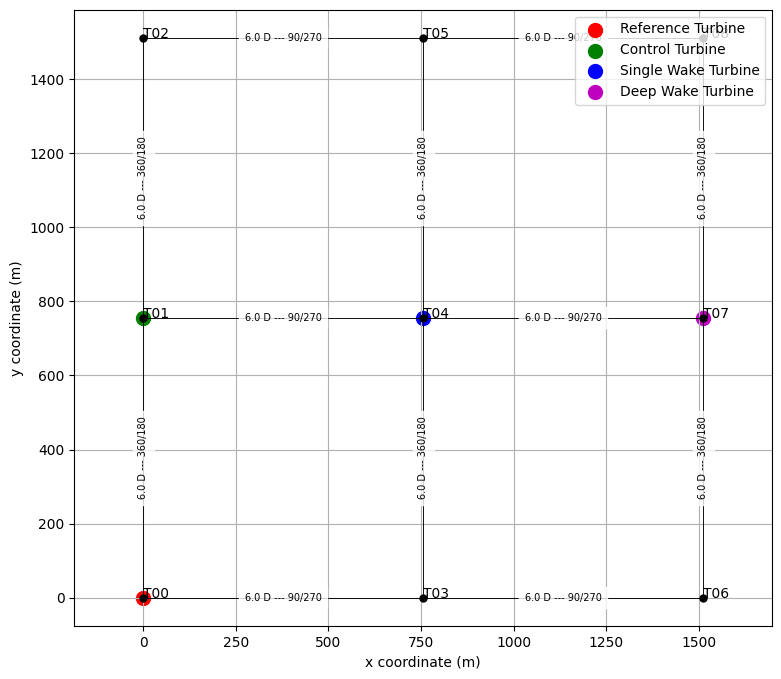

In [6]:
# Set the layout and show the locations of special turbines 
fi_benchmark.reinitialize(layout_x=layout_x, layout_y=layout_y)
fi_emg.reinitialize(layout_x=layout_x, layout_y=layout_y)

fig, ax = plt.subplots(figsize=(9,8))
plot_layout_with_waking_directions(fi_benchmark,
                                   limit_dist_D=D_between_turbines*1.2,
                                   ax=ax
                                   )

# Show the special turbine locations
ax.scatter(layout_x[ref_idx],layout_y[ref_idx],color='r',marker='o',s=100,label='Reference Turbine')
ax.scatter(layout_x[control_idx],layout_y[control_idx],color='g',marker='o',s=100,label='Control Turbine')
ax.scatter(layout_x[single_wake_idx],layout_y[single_wake_idx],color='b',marker='o',s=100,label='Single Wake Turbine')
ax.scatter(layout_x[deep_wake_idx],layout_y[deep_wake_idx],color='m',marker='o',s=100,label='Deep Wake Turbine')
ax.legend()

## Generate a time history of wind speed conditions to generate around a sector of west winds

Num Points 500


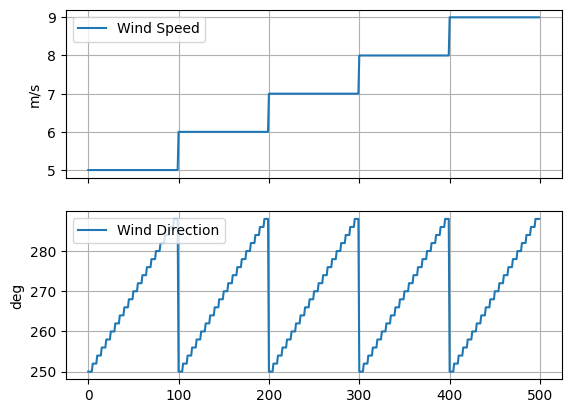

In [7]:
# Create a time history of points where the wind speed and wind direction step different combinations
ws_points = np.arange(5.0,10.0,1.0)
wd_points = np.arange(250.0, 290.0, 2,)
num_points_per_combination = 5 # How many "seconds" per combination

# I know this is dumb but will come back, can't quite work out the numpy version
ws_array = []
wd_array = []
for ws in ws_points:
    for wd in wd_points:
        for i in range(num_points_per_combination):
            ws_array.append(ws)
            wd_array.append(wd)
t = np.arange(len(ws_array))

print(f'Num Points {len(t)}')

fig, axarr = plt.subplots(2,1,sharex=True)
axarr[0].plot(t, ws_array,label='Wind Speed')
axarr[0].set_ylabel('m/s')
axarr[0].legend()
axarr[0].grid(True)
axarr[1].plot(t, wd_array,label='Wind Direction')
axarr[1].set_ylabel('deg')
axarr[1].legend()
axarr[1].grid(True)

# Simulate benchmark FLORIS and save power in kW

In [8]:
# Compute the power of the second turbine for two cases
# Baseline: The front turbine is aligned to the wind
# WakeSteering: The front turbine is yawed 25 deg
fi_benchmark.reinitialize(wind_speeds=ws_array, wind_directions=wd_array, time_series=True)
fi_benchmark.calculate_wake()
power_baseline = fi_benchmark.get_turbine_powers().squeeze() / 1000.
# power_baseline_ref = fi_benchmark.get_turbine_powers().squeeze()[:,0].flatten() / 1000.
# power_baseline_control = fi_benchmark.get_turbine_powers().squeeze()[:,1].flatten() / 1000.
# power_baseline_downstream_1 = fi_benchmark.get_turbine_powers().squeeze()[:,2].flatten() / 1000.
# power_baseline_downstream_2 = fi_benchmark.get_turbine_powers().squeeze()[:,3].flatten() / 1000.
# power_baseline_downstream_3 = fi_benchmark.get_turbine_powers().squeeze()[:,4].flatten() / 1000.

yaw_angles = np.zeros([len(ws_array),1,num_turbines]) * 25
yaw_angles[:,:,control_idx] = 25 # Set control turbine yaw angles to 25 deg
fi_benchmark.calculate_wake(yaw_angles=yaw_angles)
power_wakesteering = fi_benchmark.get_turbine_powers().squeeze() / 1000.
# power_wakesteering_ref = fi_benchmark.get_turbine_powers().squeeze()[:,0].flatten() / 1000.
# power_wakesteering_control = fi_benchmark.get_turbine_powers().squeeze()[:,1].flatten() /1000.
# power_wakesteering_downstream_1 = fi_benchmark.get_turbine_powers().squeeze()[:,2].flatten() /1000.
# power_wakesteering_downstream_2 = fi_benchmark.get_turbine_powers().squeeze()[:,3].flatten() /1000.
# power_wakesteering_downstream_3 = fi_benchmark.get_turbine_powers().squeeze()[:,4].flatten() /1000.

In [9]:
# Save the yaw angles
yaw_angles_base = 0 * yaw_angles
yaw_angels_wakesteering = yaw_angles

## Assemble the data into pandas dataframes

In [10]:
def get_df(data, wd_noise=0, ws_noise=0):

    # Define the power column names
    pow_cols = ['pow_%03d' % t for t in range(num_turbines)]
    
    # Build the dataframe
    df_ = pd.DataFrame(data=data, columns=pow_cols)

    # Add ws and wd and pow_ref
    df_ = (df_.assign(
        wd = wd_array + np.random.randn(len(wd_array))* wd_noise,
        ws = ws_array + np.random.randn(len(ws_array))* ws_noise
    ))

    # Add a pow_ref column
    # df_['pow_ref'] = df_['pow_%03d' % ref_idx]

    # Reorganize columns
    # df_ = df_[['wd','ws','pow_ref'] + pow_cols]
    df_ = df_[['wd','ws'] + pow_cols]

    return df_

In [11]:
df_baseline = get_df(power_baseline)
df_wakesteering = get_df(power_wakesteering)

# Get noisy versions
df_baseline_noisy = get_df(power_baseline, wd_noise=2., ws_noise=1.)
df_wakesteering_noisy = get_df(power_wakesteering, wd_noise=2., ws_noise=1.)

df_baseline_noisy.head()

,wd,ws,pow_000,pow_001,pow_002,pow_003,pow_004,pow_005,pow_006,pow_007,pow_008
0,252.005746,4.521054,383.695142,383.695142,383.695142,383.688147,383.688038,383.688015,383.687606,373.629262,373.700957
1,249.599982,6.542074,383.695142,383.695142,383.695142,383.688147,383.688038,383.688015,383.687606,373.629262,373.700957
2,247.058588,4.572340,383.695142,383.695142,383.695142,383.688147,383.688038,383.688015,383.687606,373.629262,373.700957
3,247.667083,5.042615,383.695142,383.695142,383.695142,383.688147,383.688038,383.688015,383.687606,373.629262,373.700957
4,252.272962,3.128644,383.695142,383.695142,383.695142,383.688147,383.688038,383.688015,383.687606,373.629262,373.700957


In [12]:
# Check stats on wd noise
noise_error = df_baseline_noisy['wd'].values  - wd_array
print(np.max(noise_error))
print(np.min(noise_error))
print(np.median(np.abs(noise_error)))

5.360139033785515
-5.96146000899418
1.340721701064993


## Tune Wake Expansion (First Index) to baseline data

In [13]:
wake_expansion_rates = np.linspace(start=0.00005, 
                                   stop=0.05,
                                   num=25)

In [14]:
df_scada = df_baseline
floris_wake_losses, scada_wake_loss = ft.sweep_velocity_model_parameter_for_overall_wake_losses(
    parameter=['wake','wake_velocity_parameters','empirical_gauss','wake_expansion_rates'],
    value_candidates=wake_expansion_rates,
    df_scada_in = df_scada,
    fi_in = fi_emg,
    param_idx=0,
    ref_turbines=[ref_idx],
    test_turbines=[single_wake_idx]
)

0.006293750000000001

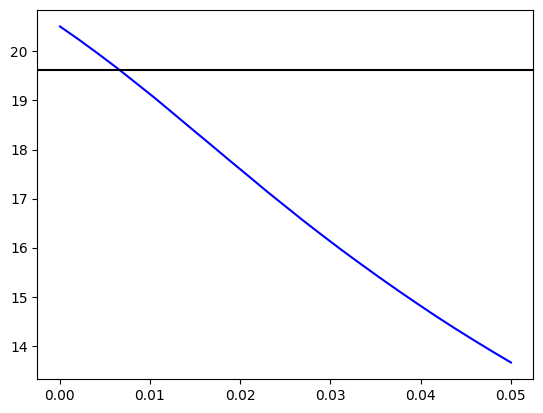

In [18]:
def select_best_result(floris_reults, 
                       scada_results,
                       value_candidates,
                       plot_result=False):
    
    error_values = (floris_reults - scada_results)**2

    best_param = value_candidates[np.argmin(error_values)]
    best_floris_result = floris_reults[np.argmin(error_values)]

    if plot_result:
        fig, ax = plt.subplots()

        ax.plot(wake_expansion_rates, floris_reults, color='b')
        ax.axhline(scada_results,color='k')

    return best_param

select_best_result(floris_wake_losses, 
                   scada_wake_loss,
                   wake_expansion_rates, 
                   plot_result=True)

In [19]:
## Repeat for the far wake
floris_wake_losses, scada_wake_loss = ft.sweep_velocity_model_parameter_for_overall_wake_losses(
    parameter=['wake','wake_velocity_parameters','empirical_gauss','wake_expansion_rates'],
    value_candidates=wake_expansion_rates,
    df_scada_in = df_scada,
    fi_in = fi_emg,
    param_idx=0,
    ref_turbines=[ref_idx],
    test_turbines=[single_wake_idx]
)


In [26]:
# Instantiate a FLORIS model tuner object
floris_tuner_baseline = FlorisTuner(fi=fi_emg,
                                    df_scada=df_baseline,
                                    yaw_angles=yaw_angles_base) 

floris_tuner_baseline_noisy = FlorisTuner(fi=fi_emg,
                                    df_scada=df_baseline_noisy,
                                    yaw_angles=yaw_angles_base) 

In [40]:
wake_expansion_rates = np.linspace(start=0.00005, 
                                   stop=0.05,
                                   num=25)

#### Tuning to non-noisy data

Parameter 1 of 25...
Parameter 2 of 25...
Parameter 3 of 25...
Parameter 4 of 25...
Parameter 5 of 25...
Parameter 6 of 25...
Parameter 7 of 25...
Parameter 8 of 25...
Parameter 9 of 25...
Parameter 10 of 25...
Parameter 11 of 25...
Parameter 12 of 25...
Parameter 13 of 25...
Parameter 14 of 25...
Parameter 15 of 25...
Parameter 16 of 25...
Parameter 17 of 25...
Parameter 18 of 25...
Parameter 19 of 25...
Parameter 20 of 25...
Parameter 21 of 25...
Parameter 22 of 25...
Parameter 23 of 25...
Parameter 24 of 25...
Parameter 25 of 25...
Computing Error


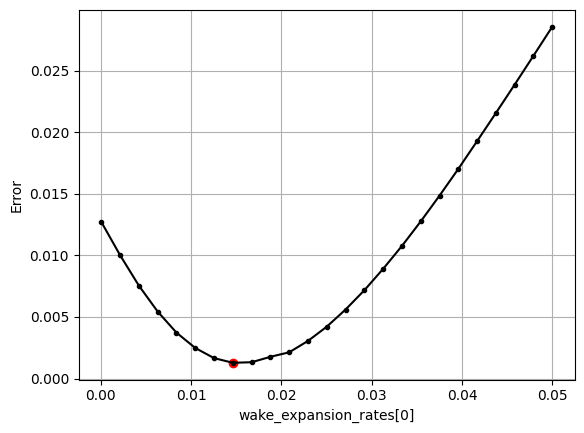

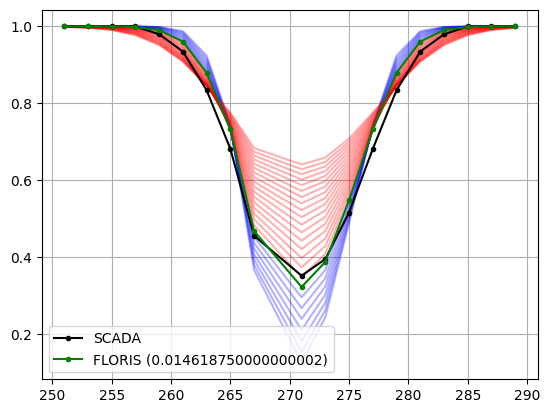

In [41]:
floris_tuner_baseline.evaluate_parameter_list(param=['wake','wake_velocity_parameters','empirical_gauss','wake_expansion_rates'],
                                          param_values=wake_expansion_rates,
                                          param_idx = 0,
                                          test_turbines=[single_wake_idx],
                                          ref_turbines=[ref_idx],
                                          use_predefined_ref=False,
                                          )

print('Computing Error')

floris_tuner_baseline.calculate_param_errors()
floris_tuner_baseline.plot_error()
floris_tuner_baseline.plot_energy_ratios()



#### Tuning to noisy data

Parameter 1 of 25...
Parameter 2 of 25...
Parameter 3 of 25...
Parameter 4 of 25...
Parameter 5 of 25...
Parameter 6 of 25...
Parameter 7 of 25...
Parameter 8 of 25...
Parameter 9 of 25...
Parameter 10 of 25...
Parameter 11 of 25...
Parameter 12 of 25...
Parameter 13 of 25...
Parameter 14 of 25...
Parameter 15 of 25...
Parameter 16 of 25...
Parameter 17 of 25...
Parameter 18 of 25...
Parameter 19 of 25...
Parameter 20 of 25...
Parameter 21 of 25...
Parameter 22 of 25...
Parameter 23 of 25...
Parameter 24 of 25...
Parameter 25 of 25...
Computing Error


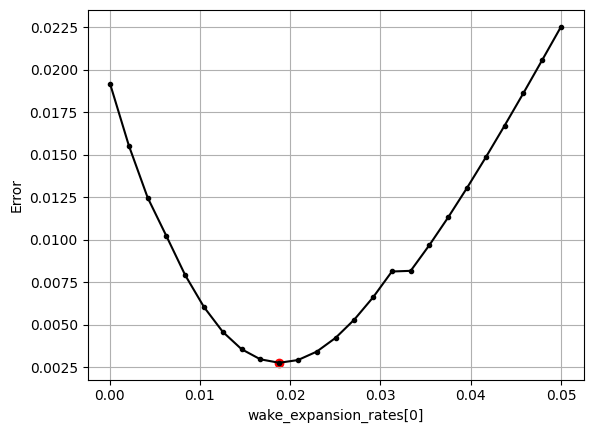

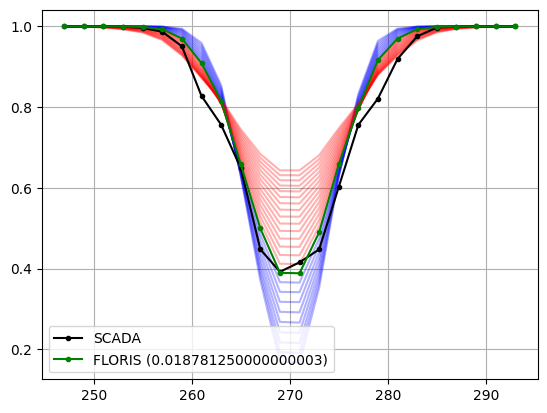

In [42]:
floris_tuner_baseline_noisy.evaluate_parameter_list(param=['wake','wake_velocity_parameters','empirical_gauss','wake_expansion_rates'],
                                          param_values=wake_expansion_rates,
                                          param_idx = 0,
                                          test_turbines=[single_wake_idx],
                                          ref_turbines=[ref_idx],
                                          use_predefined_ref=False,
                                          )

print('Computing Error')

floris_tuner_baseline_noisy.calculate_param_errors()
floris_tuner_baseline_noisy.plot_error()
floris_tuner_baseline_noisy.plot_energy_ratios()

In [43]:
# Save the best FI parameters
fi_emg_2 = floris_tuner_baseline.apply_best_param()
fi_emg_2_noisy = floris_tuner_baseline_noisy.apply_best_param()


## Tune second index in recovery

In [44]:
# Instantiate a FLORIS model tuner object
floris_tuner_baseline = FlorisTuner(fi=fi_emg_2,
                                    df_scada=df_baseline,
                                    yaw_angles=yaw_angles_base) 

floris_tuner_baseline_noisy = FlorisTuner(fi=fi_emg_2_noisy,
                                    df_scada=df_baseline_noisy,
                                    yaw_angles=yaw_angles_base) 

Parameter 1 of 25...
Parameter 2 of 25...
Parameter 3 of 25...
Parameter 4 of 25...
Parameter 5 of 25...
Parameter 6 of 25...
Parameter 7 of 25...
Parameter 8 of 25...
Parameter 9 of 25...
Parameter 10 of 25...
Parameter 11 of 25...
Parameter 12 of 25...
Parameter 13 of 25...
Parameter 14 of 25...
Parameter 15 of 25...
Parameter 16 of 25...
Parameter 17 of 25...
Parameter 18 of 25...
Parameter 19 of 25...
Parameter 20 of 25...
Parameter 21 of 25...
Parameter 22 of 25...
Parameter 23 of 25...
Parameter 24 of 25...
Parameter 25 of 25...
Computing Error


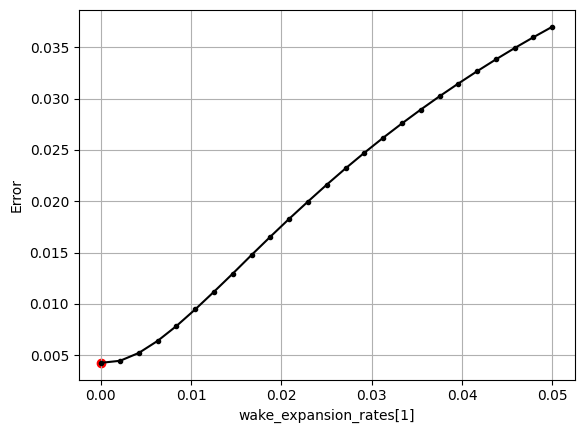

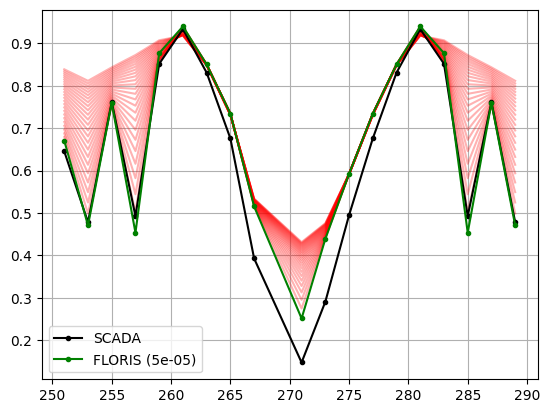

In [45]:
floris_tuner_baseline.evaluate_parameter_list(param=['wake','wake_velocity_parameters','empirical_gauss','wake_expansion_rates'],
                                          param_values=wake_expansion_rates,
                                          param_idx = 1,
                                          test_turbines=[deep_wake_idx],
                                          ref_turbines=[ref_idx],
                                          use_predefined_ref=False,
                                          )

print('Computing Error')

floris_tuner_baseline.calculate_param_errors()
floris_tuner_baseline.plot_error()
floris_tuner_baseline.plot_energy_ratios()

Parameter 1 of 25...
Parameter 2 of 25...
Parameter 3 of 25...
Parameter 4 of 25...
Parameter 5 of 25...
Parameter 6 of 25...
Parameter 7 of 25...
Parameter 8 of 25...
Parameter 9 of 25...
Parameter 10 of 25...
Parameter 11 of 25...
Parameter 12 of 25...
Parameter 13 of 25...
Parameter 14 of 25...
Parameter 15 of 25...
Parameter 16 of 25...
Parameter 17 of 25...
Parameter 18 of 25...
Parameter 19 of 25...
Parameter 20 of 25...
Parameter 21 of 25...
Parameter 22 of 25...
Parameter 23 of 25...
Parameter 24 of 25...
Parameter 25 of 25...
Computing Error


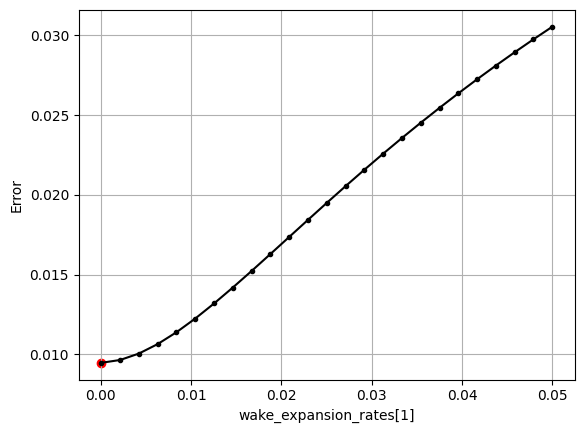

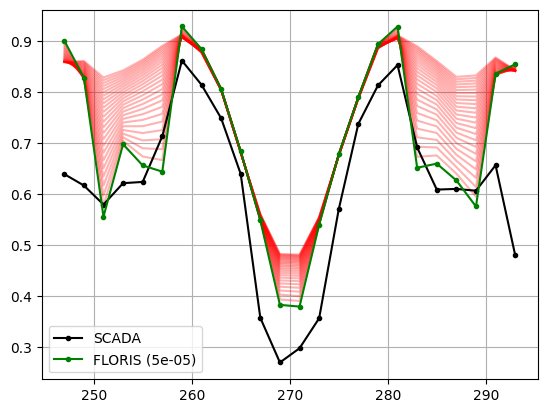

In [47]:
floris_tuner_baseline_noisy.evaluate_parameter_list(param=['wake','wake_velocity_parameters','empirical_gauss','wake_expansion_rates'],
                                          param_values=wake_expansion_rates,
                                          param_idx = 1,
                                          test_turbines=[deep_wake_idx],
                                          ref_turbines=[ref_idx],
                                          use_predefined_ref=False,
                                          )

print('Computing Error')

floris_tuner_baseline_noisy.calculate_param_errors()
floris_tuner_baseline_noisy.plot_error()
floris_tuner_baseline_noisy.plot_energy_ratios()

In [49]:
# Save the best FI parameters
fi_emg_3 = floris_tuner_baseline.apply_best_param()
fi_emg_3_noisy = floris_tuner_baseline_noisy.apply_best_param()

## Repeat on wake steering data

In [50]:
# Combine yaw angle matrices
yaw_total = np.concatenate([yaw_angles_base, yaw_angels_wakesteering], axis=0)

# Add the df_mode column
df_baseline['df_mode'] = 'baseline'
df_baseline_noisy['df_mode'] = 'baseline'
df_wakesteering['df_mode'] = 'wakesteering'
df_wakesteering_noisy['df_mode'] = 'wakesteering'

# Combine the dataframes
df_combined = pd.concat([df_baseline,df_wakesteering])
df_combined_noisy = pd.concat([df_baseline_noisy,df_wakesteering_noisy])


In [51]:
floris_tuner_wake_steering = FlorisTuner(fi=fi_emg_3,
                                    df_scada=df_combined,
                                    yaw_angles=yaw_total) 


floris_tuner_wake_steering_noisy = FlorisTuner(fi=fi_emg_3_noisy,
                                    df_scada=df_combined_noisy,
                                    yaw_angles=yaw_total) 

In [52]:
# Specify a range of wake expansion rates (assuming no breakpoints) values
horizontal_deflection_gains = np.linspace(start=0, 
                                   stop=4,
                                   num=20)

Parameter 1 of 20...
Parameter 2 of 20...
Parameter 3 of 20...
Parameter 4 of 20...
Parameter 5 of 20...
Parameter 6 of 20...
Parameter 7 of 20...
Parameter 8 of 20...
Parameter 9 of 20...
Parameter 10 of 20...
Parameter 11 of 20...
Parameter 12 of 20...
Parameter 13 of 20...
Parameter 14 of 20...
Parameter 15 of 20...
Parameter 16 of 20...
Parameter 17 of 20...
Parameter 18 of 20...
Parameter 19 of 20...
Parameter 20 of 20...
Computing Error


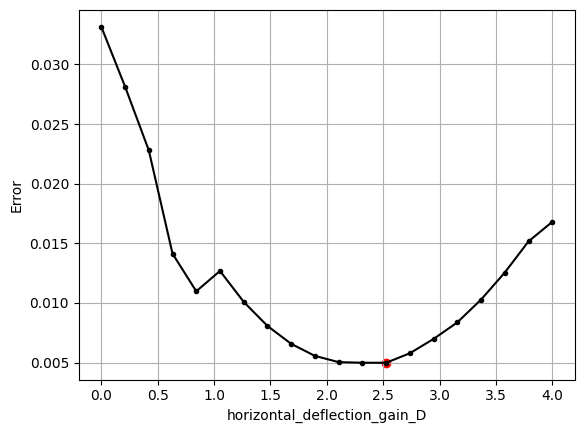

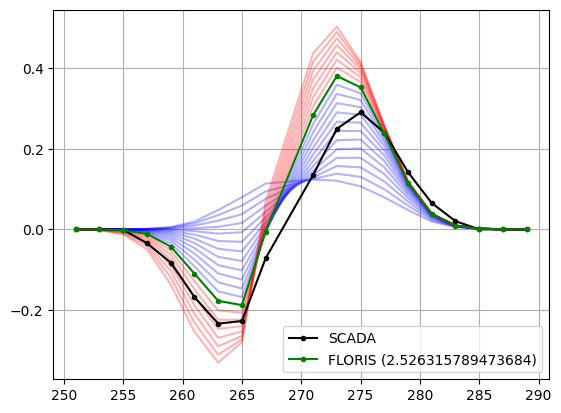

In [53]:
floris_tuner_wake_steering.evaluate_parameter_list(param=['wake','wake_deflection_parameters','empirical_gauss','horizontal_deflection_gain_D'],
                                          param_values=horizontal_deflection_gains,
                                          test_turbines=[single_wake_idx],
                                          ref_turbines=[ref_idx],
                                          use_predefined_ref=False,
                                          compare_uplift=True,
                                          df_mode_order = ['baseline','wakesteering']
                                          )


print('Computing Error')

floris_tuner_wake_steering.calculate_param_errors(compare_uplift=True)
floris_tuner_wake_steering.plot_error()
floris_tuner_wake_steering.plot_energy_ratio_uplifts()


Parameter 1 of 20...
Parameter 2 of 20...
Parameter 3 of 20...
Parameter 4 of 20...
Parameter 5 of 20...
Parameter 6 of 20...
Parameter 7 of 20...
Parameter 8 of 20...
Parameter 9 of 20...
Parameter 10 of 20...
Parameter 11 of 20...
Parameter 12 of 20...
Parameter 13 of 20...
Parameter 14 of 20...
Parameter 15 of 20...
Parameter 16 of 20...
Parameter 17 of 20...
Parameter 18 of 20...
Parameter 19 of 20...
Parameter 20 of 20...


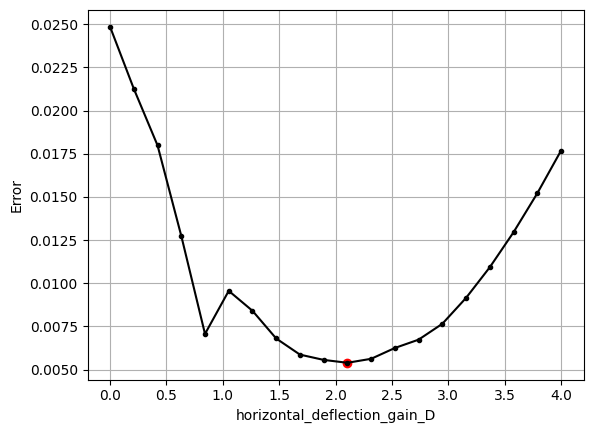

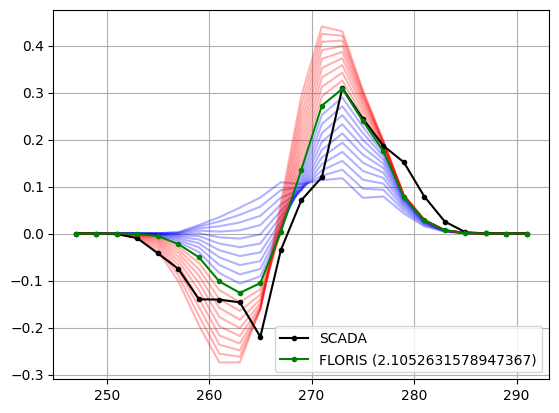

In [54]:
floris_tuner_wake_steering_noisy.evaluate_parameter_list(param=['wake','wake_deflection_parameters','empirical_gauss','horizontal_deflection_gain_D'],
                                          param_values=horizontal_deflection_gains,
                                          test_turbines=[single_wake_idx],
                                          ref_turbines=[ref_idx],
                                          use_predefined_ref=False,
                                          compare_uplift=True,
                                          df_mode_order = ['baseline','wakesteering']
                                          )


# print('Computing Error')

floris_tuner_wake_steering_noisy.calculate_param_errors(compare_uplift=True)
floris_tuner_wake_steering_noisy.plot_error()
floris_tuner_wake_steering_noisy.plot_energy_ratio_uplifts()
